<a href="https://colab.research.google.com/github/cabroderick/ML-AM-MQP/blob/main/mask_rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Testing Mask-RCNN on sample dataset provided from ME team**

In [ ]:
# uninstall improper package versions
!pip uninstall keras -y
!pip uninstall keras-nightly -y
!pip uninstall keras-Preprocessing -y
!pip uninstall keras-vis -y
!pip uninstall tensorflow -y
!pip uninstall h5py -y

Found existing installation: Keras 2.0.8
Uninstalling Keras-2.0.8:
  Successfully uninstalled Keras-2.0.8
Found existing installation: Keras-Preprocessing 1.1.2
Uninstalling Keras-Preprocessing-1.1.2:
  Successfully uninstalled Keras-Preprocessing-1.1.2
Found existing installation: tensorflow 1.13.1
Uninstalling tensorflow-1.13.1:
  Successfully uninstalled tensorflow-1.13.1
Found existing installation: h5py 2.10.0
Uninstalling h5py-2.10.0:
  Successfully uninstalled h5py-2.10.0


In [ ]:
# reinstall with proper versions
!pip install tensorflow==1.13.1
!pip install keras==2.0.8
!pip install h5py==2.10.0

  Using cached tensorflow-1.13.1-cp37-cp37m-manylinux1_x86_64.whl (92.6 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached h5py-3.5.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (4.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.5 requires tensorflow>=2.0.0, but you have tensorflow 1.13.1 which is incompatible.


  Using cached Keras-2.0.8-py2.py3-none-any.whl (276 kB)


  Using cached h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl (2.9 MB)
  Attempting uninstall: h5py
    Found existing installation: h5py 3.5.0
    Uninstalling h5py-3.5.0:
      Successfully uninstalled h5py-3.5.0


In [ ]:
# import mask rcnn and set up
%cd
!git clone https://github.com/matterport/Mask_RCNN.git
%cd Mask_RCNN/
!python setup.py install
!pip show mask-rcnn

/root
fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.
/root/Mask_RCNN
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing t

In [ ]:
# import training data
%cd
!git clone https://github.com/cabroderick/ML-AM-MQP
!ls

/root
Cloning into 'ML-AM-MQP'...
remote: Enumerating objects: 159, done.
remote: Counting objects: 100% (159/159), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 159 (delta 18), reused 87 (delta 4), pack-reused 0
Receiving objects: 100% (159/159), 132.36 MiB | 20.04 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Checking out files: 100% (109/109), done.
Mask_RCNN  ML-AM-MQP


In [ ]:
# list data contents
%cd '~/ML-AM-MQP/Data/Trial/H6'
!ls
%cd '~/ML-AM-MQP/Data/Trial/Labeled H6'
!ls
%cd

/root/ML-AM-MQP/Data/Trial/H6
A1H6COL_10X_BF_ZUYL_11.tif     A1H6COL_10X_BF_ZUYL_22.tif
A1H6COL_10X_BF_ZUYL_12.tif     A1H6COL_10X_BF_ZUYL_23.tif
A1H6COL_10X_BF_ZUYL_13.tif     A1H6COL_10X_BF_ZUYL_24.tif
A1H6COL_10X_BF_ZUYL_14.tif     A1H6COL_10X_BF_ZUYL_25.tif
A1H6COL_10X_BF_ZUYL_1.5.1.tif  A1H6COL_10X_BF_ZUYL_26.tif
A1H6COL_10X_BF_ZUYL_1.5.2.tif  A1H6COL_10X_BF_ZUYL_27.tif
A1H6COL_10X_BF_ZUYL_1.5.3.tif  A1H6COL_10X_BF_ZUYL_28.tif
A1H6COL_10X_BF_ZUYL_1.5.4.tif  A1H6COL_10X_BF_ZUYL_291.tif
A1H6COL_10X_BF_ZUYL_1.5.5.tif  A1H6COL_10X_BF_ZUYL_29.tif
A1H6COL_10X_BF_ZUYL_1.5.6.tif  A1H6COL_10X_BF_ZUYL_31.tif
A1H6COL_10X_BF_ZUYL_1.5.7.tif  A1H6COL_10X_BF_ZUYL_32.tif
A1H6COL_10X_BF_ZUYL_1.5.8.tif  A1H6COL_10X_BF_ZUYL_33.tif
A1H6COL_10X_BF_ZUYL_1.5.9.tif  A1H6COL_10X_BF_ZUYL_34.tif
A1H6COL_10X_BF_ZUYL_15.tif     A1H6COL_10X_BF_ZUYL_35.tif
A1H6COL_10X_BF_ZUYL_16.tif     A1H6COL_10X_BF_ZUYL_36.tif
A1H6COL_10X_BF_ZUYL_17.tif     A1H6COL_10X_BF_ZUYL_37.tif
A1H6COL_10X_BF_ZUYL_18.tif     A1H6COL_10

In [ ]:
# imports
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from cv2 import imread
import os
import json
import numpy as np
import urllib.request

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

In [ ]:
# configure network

class CustomConfig(Config):
    NAME = "object"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    # number of classes (including background)
    NUM_CLASSES = 1 + 2
    STEPS_PER_EPOCH = 100
    LEARNING_RATE = .001

config = CustomConfig()

# set up dataset

class AMDataset(utils.Dataset):
  def load_dataset(self, validation=False):
    IMAGES_DIR = "/root/ML-AM-MQP/Data/Trial/H6/"
    ANNOTATIONS_DIR = '/root/ML-AM-MQP/Data/Trial/Labeled H6/'
    IMG_WIDTH = 1280
    IMG_HEIGHT = 1024

    self.add_class('dataset', 1, 'gas porosity')
    self.add_class('dataset', 2, 'lack of fusion porosity')

    val_images = 5 # keeps track of images to reserve for validation set
    total_images = len(os.listdir(IMAGES_DIR))
    for filename in os.listdir(IMAGES_DIR):
      if validation and val_images > 0:
        val_images -=1
        continue
      if (not validation) and val_images < total_images:
        val_images += 1
        continue

      image_id = filename[:-4]
      image_path = IMAGES_DIR + image_id + '.tif'
      annotation_path = ANNOTATIONS_DIR + image_id + '_labeled.json'
      self.add_image('dataset',
                     image_id=image_id, 
                     path=image_path, 
                     annotation=annotation_path,
                     width=IMG_WIDTH,
                     height=IMG_HEIGHT)

  def load_mask(self, image_id):
    class_ids = list() # list of class ids corresponding to each mask in the mask list
    image_info = self.image_info[image_id] # extract image info from data added earlier

    width = image_info['width']
    height = image_info['height']
    path = image_info['annotation']

    masks_index = 0 # keep track of index for use in masks

    boxes = self.extract_boxes(path) # extract mask data from json file
    masks = np.zeros([height, width, len(boxes)], dtype='uint8') # initialize array of masks for each bounding box
    for i in range(len(boxes)):
      box = boxes[i]
      for key in box:
        if (box[key]): # make sure box is not empty
          col_s, col_e = int(box[key][0][0]), int(box[key][0][1])
          row_s, row_e = int(box[key][1][0]), int(box[key][1][1])
          masks[row_s:row_e, col_s:col_e, masks_index] = 1
          masks_index += 1
          class_ids.append(self.class_names.index(key))

    return masks, np.array(class_ids)

  def extract_boxes(self, filename): # helper to extract bounding boxes from json
      f = open(filename,)
      data = json.load(f)

      boxes = [] # store box coordinates in a dictionary corresponding to labels

      for i in data['shapes']:
        if i['shape_type'] == 'rectangle':
          box = {'gas porosity': [], 'lack of fusion porosity': []}
          label = i['label']
          box[label] = i['points']
          boxes.append(box)
 
      return boxes

# set up train and validation data

dataset_train = AMDataset()
dataset_train.load_dataset(validation=False)
dataset_train.prepare()

dataset_val = AMDataset()
dataset_val.load_dataset(validation=True)
dataset_val.prepare()

# configure model and load coco weights

urllib.request.urlretrieve("https://github.com/matterport/Mask_RCNN/releases/download/v1.0/mask_rcnn_coco.h5", "mask_rcnn_coco.h5")
model = MaskRCNN(mode='training', model_dir='./', config=CustomConfig())
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

# train model
model.train(train_dataset=dataset_train,
            val_dataset=dataset_val,
            learning_rate=.001,
            epochs=1,
            layers='heads')

# save training results to external file
model_path = 'custom_maskrcnn_weights.h5'
model.keras_model.save_weights(model_path)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Starting at epoch 0. LR=0.001

Checkpoint Path: ./object20211108T1847/mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
 99/100 [============================>.] - ETA: 124s - loss: 1.1548 - rpn_class_loss: 0.0391 - rpn_bbox_loss: 0.2449 - mrcnn_class_loss: 0.1130 - mrcnn_bbox_loss: 0.2045 - mrcnn_mask_loss: 0.5533

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2142: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


100/100 [==============================] - 14917s - loss: 1.1472 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 0.2429 - mrcnn_class_loss: 0.1122 - mrcnn_bbox_loss: 0.2027 - mrcnn_mask_loss: 0.5505 - val_loss: 3.0320 - val_rpn_class_loss: 0.1450 - val_rpn_bbox_loss: 1.2835 - val_mrcnn_class_loss: 0.2586 - val_mrcnn_bbox_loss: 0.6724 - val_mrcnn_mask_loss: 0.6725


AttributeError: ignored

In [ ]:
# model_path = 'custom_maskrcnn_weights.h5'
# model.keras_model.save_weights(model_path)

# draw an image with detected objects
def draw_image_with_boxes(filename, boxes_list):
     # load the image
     data = pyplot.imread(filename)
     # plot the image
     pyplot.imshow(data)
     # get the context for drawing boxes
     ax = pyplot.gca()
     # plot each box
     for box in boxes_list:
          # get coordinates
          y1, x1, y2, x2 = box
          # calculate width and height of the box
          width, height = x2 - x1, y2 - y1
          # create the shape
          rect = Rectangle((x1, y1), width, height, fill=False, color='red')
          # draw the box
          ax.add_patch(rect)
     # show the plot
     pyplot.show()

# load photograph
img = load_img('/root/ML-AM-MQP/Data/Trial/H6/A1H6COL_10X_BF_ZUYL_27.tif')
img = img_to_array(img)

model = MaskRCNN(mode='inference', model_dir='./', config=CustomConfig())
model.load_weights('/root/ML-AM-MQP/Data/Trial/Labeled H6/custom_maskrcnn_weights.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

# make prediction
results = model.detect(img, verbose=0)
# visualize the results
draw_image_with_boxes('/root/ML-AM-MQP/Data/Trial/H6/A1H6COL_10X_BF_ZUYL_27.tif', results[0]['rois'])

AssertionError: ignored

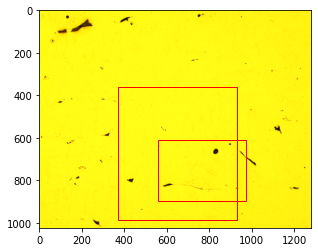

In [ ]:

# example of inference with a pre-trained coco model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from matplotlib import pyplot
from matplotlib.patches import Rectangle
 
# draw an image with detected objects
def draw_image_with_boxes(filename, boxes_list):
     # load the image
     data = pyplot.imread(filename)
     # plot the image
     pyplot.imshow(data)
     # get the context for drawing boxes
     ax = pyplot.gca()
     # plot each box
     for box in boxes_list:
          # get coordinates
          y1, x1, y2, x2 = box
          # calculate width and height of the box
          width, height = x2 - x1, y2 - y1
          # create the shape
          rect = Rectangle((x1, y1), width, height, fill=False, color='red')
          # draw the box
          ax.add_patch(rect)
     # show the plot
     pyplot.show()
 
# define the test configuration
class TestConfig(Config):
     NAME = "test"
     GPU_COUNT = 1
     IMAGES_PER_GPU = 1
     NUM_CLASSES = 3
 
# define the model
rcnn = MaskRCNN(mode='inference', model_dir='./', config=TestConfig())
# load coco model weights
rcnn.load_weights('/root/ML-AM-MQP/Data/Trial/Labeled H6/mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
rcnn.load_weights('/root/ML-AM-MQP/Data/Trial/Labeled H6/custom_maskrcnn_weights.h5', by_name=True)
# load photograph
img = load_img('/root/ML-AM-MQP/Data/Trial/H6/A1H6COL_10X_BF_ZUYL_22.tif')
img = img_to_array(img)
# make prediction
results = rcnn.detect([img], verbose=0)
# visualize the results
draw_image_with_boxes('/root/ML-AM-MQP/Data/Trial/H6/A1H6COL_10X_BF_ZUYL_22.tif', results[0]['rois'])